> This notebook was setup on databricks cluster

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
from pyspark.sql import HiveContext,Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

In [ ]:
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

In [ ]:
sc._conf.getAll()

Out[4]: [('spark.databricks.preemption.enabled', 'true'),
 ('spark.sql.hive.metastore.jars', '/databricks/databricks-hive/*'),
 ('spark.driver.tempDirectory', '/local_disk0/tmp'),
 ('spark.sql.warehouse.dir', 'dbfs:/user/hive/warehouse'),
 ('spark.databricks.managedCatalog.clientClassName',
  'com.databricks.managedcatalog.ManagedCatalogClientImpl'),
 ('spark.databricks.credential.scope.fs.gs.auth.access.tokenProviderClassName',
  'com.databricks.backend.daemon.driver.credentials.CredentialScopeGCPTokenProvider'),
 ('spark.hadoop.fs.fcfs-s3.impl.disable.cache', 'true'),
 ('spark.sql.streaming.checkpointFileManagerClass',
  'com.databricks.spark.sql.streaming.DatabricksCheckpointFileManager'),
 ('spark.databricks.clusterUsageTags.clusterAvailability',
  'SPOT_WITH_FALLBACK'),
 ('spark.databricks.service.dbutils.repl.backend',
  'com.databricks.dbconnect.ReplDBUtils'),
 ('spark.hadoop.databricks.s3.verifyBucketExists.enabled', 'false'),
 ('spark.streaming.driver.writeAheadLog.allowBatchi

In [ ]:
sc._conf.get('spark.executor.memory')

Out[5]: '16g'

In [ ]:
sc._conf.set('spark.executor.memory','16g')

Out[6]: <pyspark.conf.SparkConf at 0x7fdfe3c840a0>

In [ ]:
sc._conf.get('spark.executor.memory')

Out[7]: '16g'

In [ ]:
sc._conf.set('spark.driver.memory','16g')

Out[8]: <pyspark.conf.SparkConf at 0x7fdfe3c840a0>

In [ ]:
sc._conf.get('spark.driver.memory')

Out[9]: '16g'

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
df = spark.read.format("mongo").option('uri',f'mongodb+srv://{cluster_detail}/project_db.recipes').load()

In [ ]:
df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- actual_review_cnt: integer (nullable = true)
 |-- details: struct (nullable = true)
 |    |-- Active Time: string (nullable = true)
 |    |-- Additional Time: string (nullable = true)
 |    |-- Bake Time: string (nullable = true)
 |    |-- Chill Time: string (nullable = true)
 |    |-- Cook Time: string (nullable = true)
 |    |-- Cool Time: string (nullable = true)
 |    |-- Marinate Time: string (nullable = true)
 |    |-- Prep Time: string (nullable = true)
 |    |-- Release Pressure Time: string (nullable = true)
 |    |-- Rest Time: string (nullable = true)
 |    |-- Roast Time: string (nullable = true)
 |    |-- Servings: string (nullable = true)
 |    |-- Stand Time: string (nullable = true)
 |    |-- Total Time: string (nullable = true)
 |    |-- Yield: string (nullable = true)
 |-- directions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hierarchy: array (nullable = true)
 |    |-- element: string (co

In [ ]:
df.show(1)

+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+------------+--------------+--------------------+------+----------+----------+--------------------+--------------------+----+--------------------+
|    _id|actual_review_cnt|             details|          directions|           hierarchy|         ingredients|               intro|                name|           nutrition|picture_cnt|publish_date|publisher_name|       publisher_url|rating|rating_cnt|review_cnt|             reviews|     similar_recipes|text|                 url|
+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+------------+--------------+--------------------+------+----------+----------+--------------------+--------------------+----+--------------------+
|

## Clustering recipes based on ingredients.

- A recipe is majorly defined by its ingredients. By clustering through ingredients, we hope to excavate a pattern in recipes.
- Note, When using ingredients as features, the text of ingredients is converted to numerics through sentence-transformer based embeddings.

Outcome:
- We noticed that 4 clusters is a sensible number of clusters for the recipe data
- Arguably, 
  - The first cluster seems to majorly comprise of ingredients like flour, vanilla etc. Its a cluster of bland or near sweet dishes.
  - The second cluster seems to comprise of spicy ingredients
  - The third cluster seems to majorly comprise of cheese, oil etc. i.e Its a cluster of food with more fat.
  - The fourth cluster seems to be of recipes with beef/ chicken.

In [ ]:
# for each element in ingredients list, " ".join to make a string, store all strings in a list

def join_ingredients(ingredients):
    return ",".join([" ".join(i) for i in ingredients])

join_ingredients_udf = udf(join_ingredients, StringType())

df = df.withColumn("ingredients_str", join_ingredients_udf("ingredients")).drop("ingredients")

In [ ]:
df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- actual_review_cnt: integer (nullable = true)
 |-- details: struct (nullable = true)
 |    |-- Active Time: string (nullable = true)
 |    |-- Additional Time: string (nullable = true)
 |    |-- Bake Time: string (nullable = true)
 |    |-- Chill Time: string (nullable = true)
 |    |-- Cook Time: string (nullable = true)
 |    |-- Cool Time: string (nullable = true)
 |    |-- Marinate Time: string (nullable = true)
 |    |-- Prep Time: string (nullable = true)
 |    |-- Release Pressure Time: string (nullable = true)
 |    |-- Rest Time: string (nullable = true)
 |    |-- Roast Time: string (nullable = true)
 |    |-- Servings: string (nullable = true)
 |    |-- Stand Time: string (nullable = true)
 |    |-- Total Time: string (nullable = true)
 |    |-- Yield: string (nullable = true)
 |-- directions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hierarchy: array (nullable = true)
 |    |-- element: string (co

In [ ]:
df1 = df.select("name",'ingredients_str', 'rating')

df1 = df1.filter(df1.ingredients_str.isNotNull())

df1.printSchema()

root
 |-- name: string (nullable = true)
 |-- ingredients_str: string (nullable = true)
 |-- rating: string (nullable = true)



In [ ]:
df1.show(5)

+--------------------+--------------------+------+
|                name|     ingredients_str|rating|
+--------------------+--------------------+------+
|Irish Black Russi...|1 (1.5 fluid ounc...|   3.0|
|Sweet Butternut S...|1  unbaked 9-inch...|   5.0|
|Cheesy Tortilla S...|3 tablespoons but...|   4.5|
|Bahama Mama I Recipe|¼ fluid ounce cof...|   3.2|
|The Cheesecake Fa...|4  skinless, bone...|   4.3|
+--------------------+--------------------+------+
only showing top 5 rows



In [ ]:
emb_model = SentenceTransformer('all-MiniLM-L6-v2') # BERT distilled version. A lighter and efficient model suitable for this task

# udf for getting embeddings
def get_embeddings(str):
    return emb_model.encode(str, show_progress_bar=True).tolist()

# get the embeddings for the ingredients_str column
get_embeddings_udf = udf(get_embeddings, ArrayType(FloatType()))

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
df = df.withColumn("col_embeddings", get_embeddings_udf("ingredients_str"))

In [ ]:
def get_dense_vector(embeddings):
    return Vectors.dense(embeddings)

get_dense_vector_udf = udf(get_dense_vector, VectorUDT())

In [ ]:
# dense vectors of embeddings required to push into vector assember
df = df.withColumn("col_embeddings_dense", get_dense_vector_udf("col_embeddings"))

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
assembler = VectorAssembler(inputCols=["col_embeddings_dense"], outputCol="features")
df = assembler.transform(df)

In [ ]:
df.select('features').show(2)

+--------------------+
|            features|
+--------------------+
|[-0.0802561417222...|
|[-0.0075226528570...|
+--------------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
kmeans = KMeans(k=4, seed=1)

model = kmeans.fit(df)

# Make predictions
predictions = model.transform(df)

In [ ]:
predictions.printSchema()

root
 |-- _id: string (nullable = true)
 |-- actual_review_cnt: integer (nullable = true)
 |-- details: struct (nullable = true)
 |    |-- Active Time: string (nullable = true)
 |    |-- Additional Time: string (nullable = true)
 |    |-- Bake Time: string (nullable = true)
 |    |-- Chill Time: string (nullable = true)
 |    |-- Cook Time: string (nullable = true)
 |    |-- Cool Time: string (nullable = true)
 |    |-- Marinate Time: string (nullable = true)
 |    |-- Prep Time: string (nullable = true)
 |    |-- Release Pressure Time: string (nullable = true)
 |    |-- Rest Time: string (nullable = true)
 |    |-- Roast Time: string (nullable = true)
 |    |-- Servings: string (nullable = true)
 |    |-- Stand Time: string (nullable = true)
 |    |-- Total Time: string (nullable = true)
 |    |-- Yield: string (nullable = true)
 |-- directions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hierarchy: array (nullable = true)
 |    |-- element: string (co

In [ ]:
predictions.select('name','prediction').show(3)

+--------------------+----------+
|                name|prediction|
+--------------------+----------+
|Irish Black Russi...|         3|
|Sweet Butternut S...|         0|
|Cheesy Tortilla S...|         1|
+--------------------+----------+
only showing top 3 rows



In [ ]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 4031|
|         3| 3664|
|         2| 5479|
|         0| 8281|
+----------+-----+



Seems good distribution in terms of volume of each cluster. We aren't seeing any insiginificant minimal volume clusters indicating that perhaps 4 clusters is a good choice. Lets see silhoutte score for better quantification.

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.12033273065631633


#### While silhoutte of 1 would be best, this score isn't bad.

In [ ]:
predictions.filter(predictions.prediction == 1).select("name", 'ingredients_str').show(5)

+--------------------+--------------------+
|                name|     ingredients_str|
+--------------------+--------------------+
|Cheesy Tortilla S...|3 tablespoons but...|
|The Cheesecake Fa...|4  skinless, bone...|
|Shredded Chicken ...|¾ cup chopped oni...|
|Not Your Grandma'...|3 tablespoons but...|
|Chef John's Drunk...|8 ounces dried ri...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
ing_words_list = predictions.filter(predictions.prediction == 1).select("ingredients_str").rdd.flatMap(lambda x: x).collect()

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
stopwords = set(STOPWORDS)
stopwords.update(["1/2","1/4","3/4","cup","cups","teaspoon","teaspoons", 'ounce','½','¼','ounces','fresh','black','taste','whole','minced', 'tablespoon'])

In [ ]:
def plot_wordclouds(cluster_num = 0):
    ing_words_list = predictions.filter(predictions.prediction == cluster_num).select("ingredients_str").rdd.flatMap(lambda x: x).collect()
    
    wcloud = WordCloud(stopwords=stopwords, background_color="white").generate(" ".join(ing_words_list))
    plt.imshow(wcloud, interpolation='bilinear')
    plt.title(f'cluster {cluster_num}')
    plt.axis("off")
    plt.show()

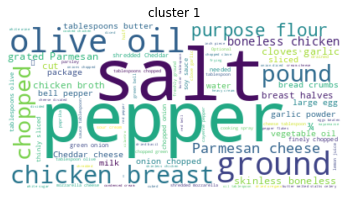

In [ ]:
# Create and generate a word cloud image:
wcloud = WordCloud(stopwords=stopwords, background_color="white").generate(" ".join(ing_words_list))

# Display the generated image:
plt.imshow(wcloud, interpolation='bilinear')
plt.title('cluster 1')
plt.axis("off")
plt.show()

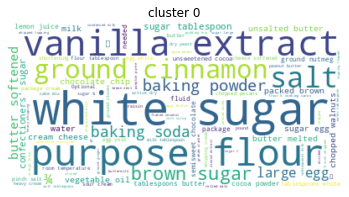

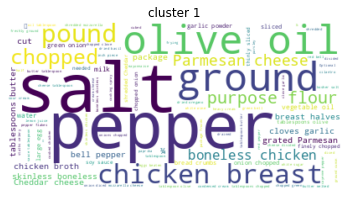

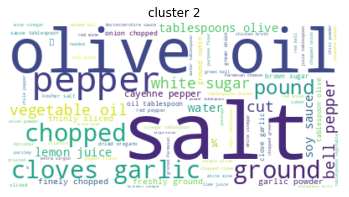

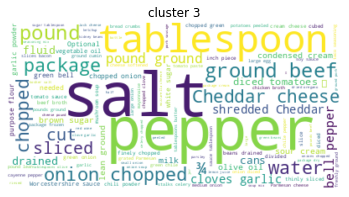

In [ ]:
for i in range(4):
    plot_wordclouds(cluster_num = i)

#### Checking silhoutte for various cluster counts

In [ ]:
def get_silhoutte_score(cluster_count = 1):
    kmeans_tmp = KMeans(k=cluster_count, seed=1)
    model_tmp = kmeans_tmp.fit(df)
    predictions_tmp = model_tmp.transform(df)
    evaluator_tmp = ClusteringEvaluator()
    silhouette_tmp = evaluator_tmp.evaluate(predictions_tmp)
    return silhouette_tmp

In [ ]:
silhouttes = []
for i in range(2,6):
    silhouttes.append((i, get_silhoutte_score(i)))

In [ ]:
silhouttes

Out[63]: [(2, 0.20756946755918582),
 (3, 0.17361115783731876),
 (4, 0.13934031009402337),
 (5, 0.13691851070677047)]

#### There isn't significant difference in silhoutte based on num of clusters. We noticed with k=4 the volume of clusters is good, as well as noticed that clusters are actually making sense (through wordclouds) so going with 4 clusters is sensible.

## PCA

- Idea is to try to represent recipe in lesser dimensional vectors
- We will see that the embeddings we got through sentence-transformer are further reduced in dimension through PCA

In [ ]:
from pyspark.ml.feature import PCA

In [ ]:
pca = PCA(k=2, inputCol="col_embeddings_dense", outputCol="pca_features")
model_pca = pca.fit(df)

In [ ]:
result_pca = model_pca.transform(df).select("pca_features")
result_pca.show(truncate=False)

+-------------------------------------------+
|pca_features                               |
+-------------------------------------------+
|[-0.16084073315008388,-0.25694815938557997]|
|[-0.18580739706377228,0.17721183301129567] |
|[0.2060124742399841,0.16930285218390081]   |
|[-0.2398065521145736,-0.19670851491577201] |
|[0.24859442796547518,0.25901069462121523]  |
|[-0.3597571571026008,-0.05508220584286323] |
|[-0.16463896805031117,0.07169701202377987] |
|[-0.08468759280677413,-0.21454008505379346]|
|[0.14723355570478408,0.14524606867207718]  |
|[-0.32868957292391915,-0.00852246673962518]|
|[-0.007200771035481244,0.454846542840171]  |
|[-0.049610078007293605,-0.1059201128812203]|
|[0.29325912462599024,0.2504384368753919]   |
|[-0.3745371165503879,0.26269136153961]     |
|[0.1731163749321709,0.29273447451820406]   |
|[-0.44758151989289413,0.014188462157118612]|
|[-0.2700980527281216,-0.19555208898405152] |
|[-0.15508542301026204,0.031431454196113894]|
|[-0.1114272967981314,0.0431411167

#### Calorie prediction through ingredients

- We expect that the ingredients would influence amount of calories in the recipe

In [ ]:
df_calorie_data = df.select("name",'ingredients_str','features','nutrition.calories')


In [ ]:
df_calorie_data = df_calorie_data.filter(df_calorie_data.calories.isNotNull() & df_calorie_data.ingredients_str.isNotNull())

In [ ]:
df_calorie_data = df_calorie_data\
    .withColumnRenamed('calories','calories_old')

df_calorie_data = df_calorie_data\
    .withColumn("label", df_calorie_data["calories_old"].cast(FloatType())).drop("calories_old")

In [ ]:
df_calorie_data.show(3)

+--------------------+--------------------+--------------------+-----+
|                name|     ingredients_str|            features|label|
+--------------------+--------------------+--------------------+-----+
|Sweet Butternut S...|1  unbaked 9-inch...|[-0.0075226528570...|254.0|
|Cheesy Tortilla S...|3 tablespoons but...|[-0.0148686477914...|245.0|
|The Cheesecake Fa...|4  skinless, bone...|[-0.0452495701611...|976.0|
+--------------------+--------------------+--------------------+-----+
only showing top 3 rows



In [ ]:
train, val = df_calorie_data.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
train.printSchema()

root
 |-- name: string (nullable = true)
 |-- ingredients_str: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: float (nullable = true)



In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
rf = RandomForestRegressor(labelCol="label", featuresCol="features")

paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 20, 30])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .build()

crossval = CrossValidator(estimator=rf,
                            estimatorParamMaps=paramGrid,
                            evaluator=RegressionEvaluator(),
                            numFolds=3)


In [ ]:
cvModel = crossval.fit(train)

In [ ]:
# get the best model

bestModel = cvModel.bestModel

# get the predictions on the validation set

predictions = bestModel.transform(val)

# get the RMSE

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

In [ ]:
rmse

Out[105]: 112.9867701216203

In [ ]:
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 112.987
